# SUMMARY
I have been retained in May 2018 by a Private Equity firm looking to expand their real estate holdings into the New York City suburbs. In particular, they are targeting 4 of the closest and wealthiest counties in the area: Westchester County, NY to the city’s north, Nassau County, NY to the city’s east, and Bergen County, NJ, and Hudson County, NJ across the Hudson River to the city’s west. They want to know, quite simply, which areas should they invest in? Which areas will have the highest ROI in a 5 year investment horizon? 

The firm hired me to answer those questions. I used a Zillow dataset that contains almost every county in the United States to answer that question. The dataset contains thousands of zip codes from across the country with the mean home sale price for each month from April 1996 to April 2018. I narrowed the zip codes down to the 201 zip codes in the relevant counties.  The data is clearly non-stationary and transformations have no effect. Splitting the data into an 80-20 train-test split, I define predicted ROI percentage as the last predicted price-the last observed price/ the final observed price. That number is then multiplied by 100 to generate a percentage:

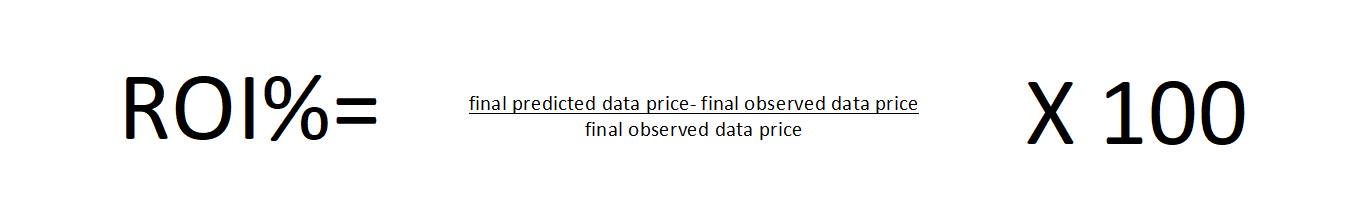

Using pmdarima's auto.arima, I found that the the predicted highest performing zip codes in the next 5 years( May 2018 to March 2023) **were 10590, 10553, 11804,  10536, and 10504**.  However, the RMSE for each is very high, the confidence intervals are very wide, and the predicted values differ greatly from the test data. The differences are wide but may be a product of the Great Financial Crash and the disruption that event caused in the real estate market.


# BUSINESS UNDERSTANDING
The New York City area real estate market is perhaps the most valuable in the country and is among the most valuable in the world.  According to Statista(https://www.statista.com/statistics/815095/new-york-metro-area-population/) , the combined population of the New York metropolitan area is almost 20 million people. When people think of the New York area, they often only think of the city proper consisting of the 5 boroughs of the Bronx, Manhattan, Queens, Brooklyn, and Staten Island. The city's fabled real estate market is lucrative but it’s important for investors to look beyond the city. The city’s suburbs form an essential part of the area’s economic ecosystem. The 4 closest counties to the city’s 4 most populated boroughs are Westchester County, NY to the north, Nassau County, NY to the east, and Hudson County, NJ and Bergen County, NJ to the west over the Hudson River. The city’s doctors, police officers, custodians, bus drivers, teachers, and bankers often reside in these counties. 

A Private Equity firm has hired me to find the zip codes with the highest ROI in the next 5 years. **This analysis will examine average home sale prices fromm every month from  April 1996 to April 2018 to forecast which zip codes have the highest ROI the next 5 years. The projections are for 5 years because that is a typical investment horizon for a PE firm**.  


# DATA UNDERSTANDING
Zillow kindly provided average home sale data for each month from  April 1996 to August 2018 for almost every zip code in the United States. Obviously, that is an immense amount of data. There are some counties with missing information so it’s  best to do a narrow search when using this dataset and to understand its limitations. The dataset consists purely of the months and the prices. 

The evaluation metric I will use is **Root Mean Squared Error(RMSE)**. RMSE is best for this case because it will penalize large error terms and outliers.

# DATA PREPARATION
First, I will import relevant libraries and read the CSV file:


In [1]:
# Importing relevant libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from pmdarima import auto_arima as pm

from pmdarima import model_selection

import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline

# Reading zillow csv
df = pd.read_csv('zillow_data.csv')


Showing the DataFrame:

In [2]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Ok, looking for the inner NYC suburban counties: Hudson, Bergen, Nassau, and Westchester.

In [3]:
#Making DataFrames for the 4 relevant counties
Westchester=df[df.CountyName == "Westchester"]
Bergen=df[df.CountyName == "Bergen"]
Nassau=df[df.CountyName == "Nassau"]
Hudson=df[df.CountyName == "Hudson"]

Remember, I'm only looking for NY area counties so let's check and make sure sure that every zip code is in the NYC area.

In [4]:
#A check to see if there is a duplicate county name in another state.
def area_check(county):
    print(county.value_counts())

In [5]:
area_check(Nassau['State'])

NY    63
FL     4
Name: State, dtype: int64


In [6]:
area_check(Bergen['State'])

NJ    65
Name: State, dtype: int64


In [7]:
area_check(Westchester['State'])

NY    61
Name: State, dtype: int64


In [8]:
area_check(Hudson['State'])

NJ    13
Name: State, dtype: int64


So, only the name 'Nassau' has zip codes outside of the NYC area.

In [9]:
#Nassau DataFrame
Nassau

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1010,62234,11758,Massapequa,NY,New York,Nassau,1011,183700.0,184000.0,184300.0,...,464200,466400,468000,470400,472400,474600,476600,479300,482900,485900
1467,62154,11561,Long Beach,NY,New York,Nassau,1468,177100.0,177100.0,177200.0,...,532200,535200,536600,538100,538400,538100,537000,541400,554600,566900
1489,71743,32034,Fernandina Beach,FL,Jacksonville,Nassau,1490,97100.0,96700.0,96400.0,...,327500,330400,333600,336400,339100,341500,343200,344400,346200,348100
1597,62143,11550,Hempstead,NY,New York,Nassau,1598,133600.0,133900.0,134200.0,...,316900,320400,323200,325800,327100,327800,328200,329800,334400,339100
2277,62133,11520,Freeport,NY,New York,Nassau,2278,144700.0,144600.0,144500.0,...,346700,350100,351500,353000,354800,356900,358700,360700,363900,366700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12008,62212,11732,East Norwich,NY,New York,Nassau,12009,279100.0,278900.0,278700.0,...,617900,624300,625500,626100,626800,629300,634200,639600,649600,660500
12592,71735,32009,Bryceville,FL,Jacksonville,Nassau,12593,74000.0,74600.0,75100.0,...,198900,200000,200600,200700,200500,200300,200100,200200,201200,202700
12628,62128,11509,Atlantic Beach,NY,New York,Nassau,12629,322600.0,323300.0,323900.0,...,805100,809300,814300,818300,823900,831400,834700,842500,861400,880000
12835,62158,11568,Old Westbury,NY,New York,Nassau,12836,841900.0,847400.0,852700.0,...,2232100,2233100,2233000,2238700,2243800,2255100,2275600,2283800,2277300,2268400


Obviously, Jacksonville is not in the NYC area so it must be eliminated. First, zip codes in Florida must be indentified:

In [10]:
# Identifiying the Nassau County, FL zip codes.
Nassau[Nassau.State == "FL"]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1489,71743,32034,Fernandina Beach,FL,Jacksonville,Nassau,1490,97100.0,96700.0,96400.0,...,327500,330400,333600,336400,339100,341500,343200,344400,346200,348100
5642,71785,32097,Yulee,FL,Jacksonville,Nassau,5643,74500.0,74100.0,73700.0,...,195600,195700,195900,196400,197100,198600,199700,200700,203100,205800
6786,71736,32011,Callahan,FL,Jacksonville,Nassau,6787,76700.0,76600.0,76400.0,...,189500,188900,189000,189300,190200,191600,192100,192000,194000,196900
12592,71735,32009,Bryceville,FL,Jacksonville,Nassau,12593,74000.0,74600.0,75100.0,...,198900,200000,200600,200700,200500,200300,200100,200200,201200,202700


Now, I will replace the 'FL' state name with a null value and then eliminate all nulls from the DataFrame:

In [11]:
# Replace 'FL' with nulls.
Nassau = Nassau.replace('FL', np.nan)
#Eliminate nulls and therefore all 'FL' entries.
Nassau.dropna(inplace=True)


Let's check to confirm that the Florida zip codes are gone:

In [12]:
#Checking to confirm the Florida values are gone.
area_check(Nassau['State'])

NY    63
Name: State, dtype: int64


Checking for any null values:

In [13]:
Nassau[Nassau.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [14]:
Bergen[Bergen.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [15]:
Hudson[Hudson.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [16]:
Westchester[Westchester.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800


Ok, so there is a single row with null values in Westchester County. I am going to drop it.

In [17]:
#Dropping the row with null values.
Westchester.dropna(inplace=True)


C:\Users\isaia\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [18]:
Westchester[Westchester.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


Ok, so the null values are gone. Now, I will concat the DataFrames.

In [19]:
##Concatenating the DataFrames
NYC_burbs=pd.concat([Westchester, Hudson, Bergen, Nassau], axis=0)
NYC_burbs

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1049800,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,531000,536300,538700,537400,536400,537200,539100,537700,533000,530900
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2896,61870,10573,Port Chester,NY,New York,Westchester,2897,260900.0,261400.0,261700.0,...,587100,588600,588400,585600,583900,586200,592000,596100,601400,606700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,62130,11514,Carle Place,NY,New York,Nassau,11402,186800.0,186500.0,186100.0,...,521900,525400,528400,529600,526900,523100,520600,521400,527200,533600
12008,62212,11732,East Norwich,NY,New York,Nassau,12009,279100.0,278900.0,278700.0,...,617900,624300,625500,626100,626800,629300,634200,639600,649600,660500
12628,62128,11509,Atlantic Beach,NY,New York,Nassau,12629,322600.0,323300.0,323900.0,...,805100,809300,814300,818300,823900,831400,834700,842500,861400,880000
12835,62158,11568,Old Westbury,NY,New York,Nassau,12836,841900.0,847400.0,852700.0,...,2232100,2233100,2233000,2238700,2243800,2255100,2275600,2283800,2277300,2268400


Confirming that there are no null values:

In [20]:
NYC_burbs[NYC_burbs.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


Calculating the returns during the observed period(April 1996-April 2018):


In [21]:
#Creating an ROI% category.
NYC_burbs['ROI%']= ((NYC_burbs['2018-04'])-(NYC_burbs['1996-04'])) /NYC_burbs['1996-04']*100
NYC_burbs

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,441900,444300,446300,448500,451400,454000,456500,458400,459800,153.054485
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400,161.319598
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,536300,538700,537400,536400,537200,539100,537700,533000,530900,147.275268
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,461100,465400,467800,470400,474400,476500,475400,475600,477400,159.738847
2896,61870,10573,Port Chester,NY,New York,Westchester,2897,260900.0,261400.0,261700.0,...,588600,588400,585600,583900,586200,592000,596100,601400,606700,132.541204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,62130,11514,Carle Place,NY,New York,Nassau,11402,186800.0,186500.0,186100.0,...,525400,528400,529600,526900,523100,520600,521400,527200,533600,185.653105
12008,62212,11732,East Norwich,NY,New York,Nassau,12009,279100.0,278900.0,278700.0,...,624300,625500,626100,626800,629300,634200,639600,649600,660500,136.653529
12628,62128,11509,Atlantic Beach,NY,New York,Nassau,12629,322600.0,323300.0,323900.0,...,809300,814300,818300,823900,831400,834700,842500,861400,880000,172.783633
12835,62158,11568,Old Westbury,NY,New York,Nassau,12836,841900.0,847400.0,852700.0,...,2233100,2233000,2238700,2243800,2255100,2275600,2283800,2277300,2268400,169.438176


Now let's check out the zip codes with the highest return:

In [22]:
#Sorting by ROI%.
NYC_burbs.sort_values(["ROI%"], ascending=False, inplace=True)
NYC_burbs

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,940.306122
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300,514.820955
6330,60593,7086,Weehawken,NJ,New York,Hudson,6331,169700.0,169900.0,170000.0,...,676200,695300,715100,730100,742600,749800,767700,804100,836100,392.692988
660,60643,7306,Jersey City,NJ,New York,Hudson,661,111400.0,111100.0,110900.0,...,469800,475900,484000,495800,506700,510000,515300,531900,545500,389.676840
1737,60644,7307,Jersey City,NJ,New York,Hudson,1738,114300.0,114300.0,114400.0,...,449000,458300,468100,478200,487300,496000,510600,531900,546600,378.215223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11463,61863,10560,North Salem,NY,New York,Westchester,11464,286400.0,284200.0,282100.0,...,510200,514300,515200,512500,506100,505100,508100,509900,510100,78.107542
10965,61871,10576,Pound Ridge,NY,New York,Westchester,10966,457500.0,456900.0,456200.0,...,790300,786000,788200,790400,789600,788300,791000,798600,805300,76.021858
14530,61831,10518,Lewisboro,NY,New York,Westchester,14531,341700.0,339700.0,337600.0,...,603600,610100,617600,607200,587000,570100,554400,546700,556700,62.920691
10030,61880,10590,Lewisboro,NY,New York,Westchester,10031,327700.0,326000.0,324200.0,...,541100,537500,531000,521100,512900,510400,509900,509200,510200,55.691181


Here are the top 5 returners:

In [23]:
#Top 5 returners
NYC_burbs.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,940.306122
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300,514.820955
6330,60593,7086,Weehawken,NJ,New York,Hudson,6331,169700.0,169900.0,170000.0,...,676200,695300,715100,730100,742600,749800,767700,804100,836100,392.692988
660,60643,7306,Jersey City,NJ,New York,Hudson,661,111400.0,111100.0,110900.0,...,469800,475900,484000,495800,506700,510000,515300,531900,545500,389.676840
1737,60644,7307,Jersey City,NJ,New York,Hudson,1738,114300.0,114300.0,114400.0,...,449000,458300,468100,478200,487300,496000,510600,531900,546600,378.215223


The 5 highest ROI% zip codes for the dataset are all in Hudson County, NJ and are either in or near Jersey City, NJ. 

# Modeling

First, I will emply a function that will transform the dataset into a longform DataFrame where each zip code represents a column and each date represents a month:

In [24]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Before I melt the data, I need to eliminate any columns with string values so I have to eliminate the ROI% column:

In [25]:
NYC_burbs.drop('ROI%', axis=1, inplace=True)

Metling the data on the NYC suburbs:

In [26]:
Suburbs = pd.DataFrame()
for i in NYC_burbs['RegionName']:
    x = melt_data(NYC_burbs[NYC_burbs['RegionName'] == i])  
    Suburbs = pd.concat([Suburbs, x], axis=1)
    Suburbs.rename(columns = {'value':i}, inplace = True)
Suburbs

,7302,7030,7086,7306,7307,11559,10580,7087,11030,11561,...,7417,10536,7643,10553,10577,10560,10576,10518,10590,10526
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,137200.0,301600.0,169700.0,111400.0,114300.0,355900.0,491700.0,127300.0,512500.0,177100.0,...,534300.0,344800.0,171500.0,182300.0,581800.0,286400.0,457500.0,341700.0,327700.0,300300.0
1996-05-01,137800.0,302700.0,169900.0,111100.0,114300.0,357100.0,492400.0,127000.0,513300.0,177100.0,...,533700.0,343800.0,171200.0,181100.0,585700.0,284200.0,456900.0,339700.0,326000.0,297800.0
1996-06-01,138500.0,303800.0,170000.0,110900.0,114400.0,358300.0,493100.0,126700.0,514000.0,177200.0,...,533100.0,342800.0,170800.0,179900.0,589600.0,282100.0,456200.0,337600.0,324200.0,295400.0
1996-07-01,139100.0,304800.0,170100.0,110600.0,114500.0,359600.0,493500.0,126400.0,514600.0,177200.0,...,532400.0,341700.0,170400.0,178800.0,592900.0,280200.0,455400.0,335300.0,322400.0,293000.0
1996-08-01,139600.0,305800.0,170200.0,110300.0,114800.0,360900.0,493600.0,126100.0,515000.0,177300.0,...,531800.0,340500.0,170100.0,177700.0,595500.0,278500.0,454500.0,333100.0,320600.0,290700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1447800.0,1853500.0,742600.0,506700.0,487300.0,1190900.0,1716400.0,410500.0,1704000.0,538100.0,...,984100.0,635800.0,310200.0,336800.0,1041300.0,506100.0,789600.0,587000.0,512900.0,464400.0
2018-01-01,1454900.0,1852200.0,749800.0,510000.0,496000.0,1211000.0,1726700.0,415500.0,1712400.0,537000.0,...,985700.0,634000.0,312000.0,336800.0,1046300.0,505100.0,788300.0,570100.0,510400.0,465600.0
2018-02-01,1453900.0,1854400.0,767700.0,515300.0,510600.0,1223100.0,1735600.0,424000.0,1719900.0,541400.0,...,985600.0,635000.0,313500.0,335100.0,1048100.0,508100.0,791000.0,554400.0,509900.0,461800.0


In [27]:
# Null Check
Suburbs[Suburbs.isnull().any(axis=1)] 

,7302,7030,7086,7306,7307,11559,10580,7087,11030,11561,...,7417,10536,7643,10553,10577,10560,10576,10518,10590,10526
time,,,,,,,,,,,,,,,,,,,,,


## Train-Test Split

In [28]:
f'{265*.8} months will be in training set'

'212.0 months will be in training set'

In [29]:
f'{265*.2} months will be in test set'

'53.0 months will be in test set'

In [30]:
# Train test split with the first 212 out 265 months as training data.
train_1 = Suburbs.iloc[:212, :]
# The last 60 months, 5 years, will be used as test data.
test_1 = Suburbs.iloc[212:, :]

Here's the train data:

In [31]:
# Train DataFrame
train_1

,7302,7030,7086,7306,7307,11559,10580,7087,11030,11561,...,7417,10536,7643,10553,10577,10560,10576,10518,10590,10526
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,137200.0,301600.0,169700.0,111400.0,114300.0,355900.0,491700.0,127300.0,512500.0,177100.0,...,534300.0,344800.0,171500.0,182300.0,581800.0,286400.0,457500.0,341700.0,327700.0,300300.0
1996-05-01,137800.0,302700.0,169900.0,111100.0,114300.0,357100.0,492400.0,127000.0,513300.0,177100.0,...,533700.0,343800.0,171200.0,181100.0,585700.0,284200.0,456900.0,339700.0,326000.0,297800.0
1996-06-01,138500.0,303800.0,170000.0,110900.0,114400.0,358300.0,493100.0,126700.0,514000.0,177200.0,...,533100.0,342800.0,170800.0,179900.0,589600.0,282100.0,456200.0,337600.0,324200.0,295400.0
1996-07-01,139100.0,304800.0,170100.0,110600.0,114500.0,359600.0,493500.0,126400.0,514600.0,177200.0,...,532400.0,341700.0,170400.0,178800.0,592900.0,280200.0,455400.0,335300.0,322400.0,293000.0
1996-08-01,139600.0,305800.0,170200.0,110300.0,114800.0,360900.0,493600.0,126100.0,515000.0,177300.0,...,531800.0,340500.0,170100.0,177700.0,595500.0,278500.0,454500.0,333100.0,320600.0,290700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01,709200.0,1213800.0,525100.0,270500.0,261300.0,832800.0,1405300.0,254100.0,1227600.0,430000.0,...,910700.0,579900.0,290300.0,224700.0,1051600.0,435400.0,725200.0,487700.0,467200.0,418200.0
2013-08-01,722500.0,1230600.0,527900.0,270800.0,260200.0,844600.0,1397700.0,255400.0,1238500.0,426200.0,...,914900.0,583500.0,292500.0,226900.0,1064800.0,436100.0,723500.0,475300.0,459500.0,424200.0
2013-09-01,730500.0,1244400.0,526000.0,272500.0,261400.0,858100.0,1394400.0,255800.0,1248500.0,421900.0,...,910700.0,587000.0,294400.0,229200.0,1075300.0,438100.0,722400.0,467900.0,457500.0,428800.0


Here's the test data:

In [32]:
# Test Data
test_1

,7302,7030,7086,7306,7307,11559,10580,7087,11030,11561,...,7417,10536,7643,10553,10577,10560,10576,10518,10590,10526
time,,,,,,,,,,,,,,,,,,,,,
2013-12-01,739900.0,1253500.0,519000.0,263900.0,264600.0,884200.0,1410900.0,250400.0,1285600.0,409500.0,...,929600.0,615600.0,292400.0,249700.0,1107000.0,454200.0,726600.0,459700.0,505400.0,441400.0
2014-01-01,747500.0,1258800.0,514100.0,261200.0,267700.0,889000.0,1422100.0,250600.0,1300600.0,408400.0,...,929500.0,620200.0,292300.0,253700.0,1116200.0,460500.0,732500.0,462700.0,532800.0,453500.0
2014-02-01,761300.0,1277000.0,512200.0,260200.0,272500.0,888800.0,1427000.0,253900.0,1309100.0,404800.0,...,924300.0,619900.0,292400.0,257000.0,1118900.0,462100.0,734100.0,455700.0,544100.0,459300.0
2014-03-01,774100.0,1295100.0,508000.0,261100.0,278500.0,886300.0,1428600.0,258600.0,1309900.0,399200.0,...,922200.0,617900.0,290600.0,259400.0,1112200.0,461300.0,730800.0,440100.0,533000.0,462300.0
2014-04-01,778700.0,1304900.0,510100.0,264400.0,284300.0,892800.0,1436800.0,263200.0,1318700.0,397100.0,...,922200.0,616700.0,285400.0,261500.0,1099900.0,463200.0,728800.0,430200.0,516600.0,463100.0
2014-05-01,771300.0,1304200.0,523700.0,268500.0,288300.0,911300.0,1452000.0,264800.0,1339600.0,399100.0,...,921300.0,616500.0,281700.0,266200.0,1084500.0,469000.0,729000.0,436200.0,503500.0,464600.0
2014-06-01,759800.0,1300600.0,538600.0,273100.0,292000.0,932000.0,1458700.0,264700.0,1360500.0,401300.0,...,920100.0,611200.0,281900.0,271700.0,1075000.0,473700.0,730100.0,447500.0,490100.0,467500.0
2014-07-01,753800.0,1302800.0,542900.0,278600.0,297200.0,947400.0,1457400.0,265500.0,1376200.0,403500.0,...,919400.0,601300.0,278300.0,276700.0,1066000.0,474200.0,733500.0,451400.0,479500.0,465900.0
2014-08-01,747700.0,1308900.0,541100.0,285300.0,302500.0,959400.0,1461400.0,268500.0,1391700.0,406400.0,...,921300.0,596500.0,268800.0,282700.0,1054100.0,471500.0,745400.0,448300.0,472700.0,462200.0


Here is a function that test for stationarity:

In [33]:
#Function to check for stationarity for each zipcode. 
def dftest_stationarity(data):
    for x in data:
        # Check to see if the p-value ≤ .05. If so, it returns the the stationary zipcodes with associated values.
        if  adfuller(data[x])[1] <=.05: 
            return(x, adfuller(data[x])[0:6])
        

Let's check for stationarity in the Suburbs dataset:

In [34]:
dftest_stationarity(Suburbs)

(7093,
 (-2.8859795010040825,
  0.04700285173064798,
  13,
  251,
  {'1%': -3.4566744514553016,
   '5%': -2.8731248767783426,
   '10%': -2.5729436702592023},
  4081.2791763890964))

Only 07093 is stationary.

Now, for the training set:

In [35]:
dftest_stationarity(train_1)

None are stationary. Let's try differencing the values to see if that makaes any difference:

In [36]:
#Differenced data of 1 month
train_1.diff()[1:]

,7302,7030,7086,7306,7307,11559,10580,7087,11030,11561,...,7417,10536,7643,10553,10577,10560,10576,10518,10590,10526
time,,,,,,,,,,,,,,,,,,,,,
1996-05-01,600.0,1100.0,200.0,-300.0,0.0,1200.0,700.0,-300.0,800.0,0.0,...,-600.0,-1000.0,-300.0,-1200.0,3900.0,-2200.0,-600.0,-2000.0,-1700.0,-2500.0
1996-06-01,700.0,1100.0,100.0,-200.0,100.0,1200.0,700.0,-300.0,700.0,100.0,...,-600.0,-1000.0,-400.0,-1200.0,3900.0,-2100.0,-700.0,-2100.0,-1800.0,-2400.0
1996-07-01,600.0,1000.0,100.0,-300.0,100.0,1300.0,400.0,-300.0,600.0,0.0,...,-700.0,-1100.0,-400.0,-1100.0,3300.0,-1900.0,-800.0,-2300.0,-1800.0,-2400.0
1996-08-01,500.0,1000.0,100.0,-300.0,300.0,1300.0,100.0,-300.0,400.0,100.0,...,-600.0,-1200.0,-300.0,-1100.0,2600.0,-1700.0,-900.0,-2200.0,-1800.0,-2300.0
1996-09-01,500.0,1000.0,200.0,-300.0,400.0,1300.0,-100.0,-200.0,500.0,100.0,...,-500.0,-1100.0,-300.0,-1200.0,2000.0,-1600.0,-1100.0,-2100.0,-1700.0,-2200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01,18400.0,20000.0,8900.0,-2000.0,600.0,5600.0,-8400.0,2600.0,12000.0,-3200.0,...,8100.0,10800.0,200.0,-1700.0,28000.0,-1800.0,4300.0,-19700.0,-11600.0,1400.0
2013-08-01,13300.0,16800.0,2800.0,300.0,-1100.0,11800.0,-7600.0,1300.0,10900.0,-3800.0,...,4200.0,3600.0,2200.0,2200.0,13200.0,700.0,-1700.0,-12400.0,-7700.0,6000.0
2013-09-01,8000.0,13800.0,-1900.0,1700.0,1200.0,13500.0,-3300.0,400.0,10000.0,-4300.0,...,-4200.0,3500.0,1900.0,2300.0,10500.0,2000.0,-1100.0,-7400.0,-2000.0,4600.0


In [37]:
dftest_stationarity(train_1.diff()[1:])

(10580,
 (-2.906870518219578,
  0.04455486323837397,
  12,
  198,
  {'1%': -3.4638151713286316,
   '5%': -2.876250632135043,
   '10%': -2.574611347821651},
  3673.1020822367127))

Only 1 zipcode, 10706 is stationary. Maybe taking the square root of the training values will help?

In [38]:
#Creating square root of training data
train_sqrt = np.sqrt(train_1)
train_sqrt

,7302,7030,7086,7306,7307,11559,10580,7087,11030,11561,...,7417,10536,7643,10553,10577,10560,10576,10518,10590,10526
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,370.405184,549.181209,411.946598,333.766385,338.082830,596.573550,701.213234,356.791255,715.891053,420.832508,...,730.958275,587.196730,414.125585,426.966041,762.758153,535.163526,676.387463,584.551110,572.450871,547.996350
1996-05-01,371.214224,550.181788,412.189277,333.316666,338.082830,597.578447,701.712192,356.370594,716.449580,420.832508,...,730.547740,586.344609,413.763217,425.558457,765.310395,533.104117,675.943785,582.837885,570.964097,545.710546
1996-06-01,372.155881,551.180551,412.310563,333.016516,338.230691,598.581657,702.210795,355.949435,716.937933,420.951304,...,730.136973,585.491247,413.279566,424.146201,767.854153,531.130869,675.425792,581.033562,569.385634,543.507130
1996-07-01,372.961124,552.086950,412.431813,332.565783,338.378486,599.666574,702.495552,355.527777,717.356257,420.951304,...,729.657454,584.551110,412.795349,422.847490,770.000000,529.339211,674.833313,579.050948,567.802783,541.294744
1996-08-01,373.630834,552.991863,412.553027,332.114438,338.821487,600.749532,702.566723,355.105618,717.635005,421.070065,...,729.246186,583.523778,412.431813,421.544778,771.686465,527.730992,674.166152,577.148161,566.215507,539.166023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01,842.140131,1101.725919,724.637841,520.096145,511.175117,912.578764,1185.453500,504.083326,1107.971119,655.743852,...,954.306031,761.511655,538.794952,474.025316,1025.475499,659.848467,851.586754,698.355210,683.520300,646.683849
2013-08-01,850.000000,1109.324119,726.567271,520.384473,510.098030,919.021218,1182.243630,505.371151,1112.879149,652.839950,...,956.504051,763.871717,540.832691,476.340215,1031.891467,660.378679,850.588032,689.420046,677.864293,651.306380
2013-09-01,854.692927,1115.526781,725.258575,522.015325,511.272921,926.336872,1180.847154,505.766745,1117.362967,649.538298,...,954.306031,766.159252,542.586399,478.748368,1036.966730,661.891230,849.941174,684.032163,676.387463,654.828222


Now, let's see if using the square root values makes the data more stationary:

In [39]:
dftest_stationarity(train_sqrt)

(11023,
 (-3.0235029287182504,
  0.03275705756320944,
  15,
  196,
  {'1%': -3.464161278384219,
   '5%': -2.876401960790147,
   '10%': -2.5746921001665974},
  327.3754946727056))

Perhaps a logarithmic transformation will make the data more stationary.


In [40]:
# Log transformed data
train_log = np.log(train_1)
train_log.head(3)

,7302,7030,7086,7306,7307,11559,10580,7087,11030,11561,...,7417,10536,7643,10553,10577,10560,10576,10518,10590,10526
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,11.829195,12.616857,12.041787,11.620883,11.646582,12.782405,13.105624,11.754302,13.147056,12.084470,...,13.188713,12.750720,12.052339,12.113409,13.273882,12.565145,13.033532,12.741688,12.699854,12.612537
1996-05-01,11.833559,12.620497,12.042965,11.618186,11.646582,12.785771,13.107047,11.751942,13.148616,12.084470,...,13.187589,12.747815,12.050588,12.106805,13.280563,12.557433,13.032220,12.735818,12.694653,12.604177
1996-06-01,11.838626,12.624125,12.043554,11.616384,11.647456,12.789126,13.108467,11.749577,13.149979,12.085034,...,13.186464,12.744902,12.048249,12.100156,13.287200,12.550017,13.030687,12.729617,12.689116,12.596086


In [41]:
dftest_stationarity(train_log)

(7087,
 (-2.952981423049992,
  0.039524798462209514,
  15,
  196,
  {'1%': -3.464161278384219,
   '5%': -2.876401960790147,
   '10%': -2.5746921001665974},
  -1719.8124441748519))

No, the log transfomation did not significantly make the data more stationary.

**So, far none of these methods have yielded a significant amount of stationary data. Therefore, it's best to use pmdarima's autoarima**.

However, before I use auto_arima, I want to add rows to my DataFrame so I can graph the predictions. First, I have to make a copy of 'Suburbs', then I will add the rows, then I will make it into a DataFrame. Lastly, I must take the DataFrame's index and convert it into an array.

In [42]:
#For Loop to get 60 more rows that will be used for subsequent 5 years
burbs_copy=Suburbs.copy(deep=True)
for i in range(1,61):
    idx = burbs_copy.tail(1).index[0] + pd.Timedelta(days=(365/12))
    burbs_copy.loc[idx] = 0
#Making the list into a DataFrame, making the index into an array

burbs_2=pd.DataFrame(burbs_copy)
#Make the index into an array
date_list=burbs_2.index.to_numpy()
dates=pd.to_datetime(date_list, format='%Y-%d-%m')
dates[265:]

DatetimeIndex(['2018-05-01 10:00:00', '2018-05-31 20:00:00',
               '2018-07-01 06:00:00', '2018-07-31 16:00:00',
               '2018-08-31 02:00:00', '2018-09-30 12:00:00',
               '2018-10-30 22:00:00', '2018-11-30 08:00:00',
               '2018-12-30 18:00:00', '2019-01-30 04:00:00',
               '2019-03-01 14:00:00', '2019-04-01 00:00:00',
               '2019-05-01 10:00:00', '2019-05-31 20:00:00',
               '2019-07-01 06:00:00', '2019-07-31 16:00:00',
               '2019-08-31 02:00:00', '2019-09-30 12:00:00',
               '2019-10-30 22:00:00', '2019-11-30 08:00:00',
               '2019-12-30 18:00:00', '2020-01-30 04:00:00',
               '2020-02-29 14:00:00', '2020-03-31 00:00:00',
               '2020-04-30 10:00:00', '2020-05-30 20:00:00',
               '2020-06-30 06:00:00', '2020-07-30 16:00:00',
               '2020-08-30 02:00:00', '2020-09-29 12:00:00',
               '2020-10-29 22:00:00', '2020-11-29 08:00:00',
               '2020-12-

Next, I will import a few time functions because it's practical to know how long the it will take to do auto_arima on 201 zipcodes:

In [43]:
#importing time functions
import timeit
import time


In [44]:
%%time

import pmdarima as pm
from pmdarima import model_selection
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.dates as mdates
#This is an empty dictionary that will later hold our ROI% values.
ROI_dict={}
for area in Suburbs:
    #80/20 split for each zipcode
    train, test = model_selection.train_test_split(Suburbs[area], train_size=.8)

    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                         max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                         stepwise=True, suppress_warnings=True, D=5, max_D=5,
                         error_action='ignore')
    #printing model summary
    print(model.summary())
    #Creating the predictions. 
    #conf_int returns confidence level at 95% level.
    preds, conf_int = model.predict(n_periods=test.shape[0]+60, return_conf_int=True)
   


    
    #Print the errors:
    print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds[:53])))
    
    #Printing how far the values have changed from the end of the 2
    print("From $ : %.3f" % test[52], " on 11/1/2013 to $ %.3f" % preds[112], " on 4/1/2018 for", area)
    #
    ROI_percent=((preds[112]-test[52])/(test[52])*100)
    print(("ROI_percent: %.3f"%  ROI_percent))
    #ROI_percent_real=((test[52]-train[211])/(train[211])*100)
    #print(("Actual Test Data ROI_percent: %.3f"%  ROI_percent_real))

    #Graphing, 'dates' is used as the x values while the train, test, and prediction values are the y values
    # Lines 45-55 will graph the training, test, predicted values and the confidence intervals for every zipcode. 
    # Section is under comments so notebook can load more easily. Uncomment if you want to see graphs.
    #plt.figure(figsize=(12,6))
    #plt.plot(dates[:212], train)
    #plt.plot(dates[212:265], test)
    #plt.plot(dates[212:], preds)
    #plt.fill_between(dates[212:], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    #plt.xlabel('Year',fontsize=14)
    #plt.ylabel('Home Value',fontsize=14)
    #plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    #plt.title(f'{area} Prices and Next 5 year projections ')
    #plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    #plt.show()
    
    ROI_dict[area] = ROI_percent

stop = timeit.default_timer()
    
    
    
    


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1980.156
Date:                Sun, 21 Aug 2022   AIC                           3964.313
Time:                        13:15:08   BIC                           3971.007
Sample:                             0   HQIC                          3967.019
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0509      0.013      3.885      0.000       0.025       0.077
sigma2      9.018e+06   6.49e-11   1.39e+17      0.000    9.02e+06    9.02e+06
Ljung-Box (L1) (Q):                  26.89   Jarque-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2076.609
Date:                Sun, 21 Aug 2022   AIC                           4155.217
Time:                        13:15:14   BIC                           4158.564
Sample:                             0   HQIC                          4156.570
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.252e+07   1.14e+06     19.781      0.000    2.03e+07    2.47e+07
Ljung-Box (L1) (Q):                  63.17   Jarque-Bera (JB):               251.12
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2065.830
Date:                Sun, 21 Aug 2022   AIC                           4133.660
Time:                        13:15:16   BIC                           4137.007
Sample:                             0   HQIC                          4135.013
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.032e+07   8.29e+05     24.526      0.000    1.87e+07    2.19e+07
Ljung-Box (L1) (Q):                   9.15   Jarque-Bera (JB):               765.34
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1704.994
Date:                Sun, 21 Aug 2022   AIC                           3411.989
Time:                        13:15:17   BIC                           3415.336
Sample:                             0   HQIC                          3413.342
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.555e+05    3.1e+04     21.149      0.000    5.95e+05    7.16e+05
Ljung-Box (L1) (Q):                  23.64   Jarque-Bera (JB):               367.31
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1716.762
Date:                Sun, 21 Aug 2022   AIC                           3435.525
Time:                        13:15:19   BIC                           3438.872
Sample:                             0   HQIC                          3436.878
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.331e+05   4.72e+04     15.520      0.000    6.41e+05    8.26e+05
Ljung-Box (L1) (Q):                  38.81   Jarque-Bera (JB):                59.31
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1612.556
Date:                Sun, 21 Aug 2022   AIC                           3229.112
Time:                        13:15:21   BIC                           3235.806
Sample:                             0   HQIC                          3231.818
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0286      0.011      2.662      0.008       0.008       0.050
sigma2      2.689e+05   1.27e+04     21.135      0.000    2.44e+05    2.94e+05
Ljung-Box (L1) (Q):                  38.89   Jarque-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1625.001
Date:                Sun, 21 Aug 2022   AIC                           3252.001
Time:                        13:15:24   BIC                           3255.348
Sample:                             0   HQIC                          3253.354
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.081e+05   1.41e+04     21.921      0.000    2.81e+05    3.36e+05
Ljung-Box (L1) (Q):                  24.45   Jarque-Bera (JB):               450.03
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1638.560
Date:                Sun, 21 Aug 2022   AIC                           3279.120
Time:                        13:15:26   BIC                           3282.467
Sample:                             0   HQIC                          3280.473
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.506e+05   1.96e+04     17.879      0.000    3.12e+05    3.89e+05
Ljung-Box (L1) (Q):                  13.06   Jarque-Bera (JB):               146.23
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1607.540
Date:                Sun, 21 Aug 2022   AIC                           3219.080
Time:                        13:15:28   BIC                           3225.774
Sample:                             0   HQIC                          3221.786
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0271      0.011      2.406      0.016       0.005       0.049
sigma2      2.568e+05   1.47e+04     17.460      0.000    2.28e+05    2.86e+05
Ljung-Box (L1) (Q):                  34.41   Jarque-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1610.643
Date:                Sun, 21 Aug 2022   AIC                           3223.286
Time:                        13:15:29   BIC                           3226.633
Sample:                             0   HQIC                          3224.639
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.687e+05   1.13e+04     23.883      0.000    2.47e+05    2.91e+05
Ljung-Box (L1) (Q):                  25.19   Jarque-Bera (JB):               721.27
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1769.854
Date:                Sun, 21 Aug 2022   AIC                           3541.708
Time:                        13:15:31   BIC                           3545.055
Sample:                             0   HQIC                          3543.061
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.213e+06   6.71e+04     18.085      0.000    1.08e+06    1.34e+06
Ljung-Box (L1) (Q):                  40.35   Jarque-Bera (JB):               157.68
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1765.160
Date:                Sun, 21 Aug 2022   AIC                           3532.320
Time:                        13:15:33   BIC                           3535.667
Sample:                             0   HQIC                          3533.673
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.16e+06   5.49e+04     21.129      0.000    1.05e+06    1.27e+06
Ljung-Box (L1) (Q):                  44.42   Jarque-Bera (JB):               367.68
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1756.603
Date:                Sun, 21 Aug 2022   AIC                           3515.207
Time:                        13:15:37   BIC                           3518.554
Sample:                             0   HQIC                          3516.560
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.069e+06   5.77e+04     18.522      0.000    9.56e+05    1.18e+06
Ljung-Box (L1) (Q):                  30.79   Jarque-Bera (JB):               173.08
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1906.079
Date:                Sun, 21 Aug 2022   AIC                           3814.157
Time:                        13:15:39   BIC                           3817.504
Sample:                             0   HQIC                          3815.510
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.438e+06   1.68e+05     26.466      0.000    4.11e+06    4.77e+06
Ljung-Box (L1) (Q):                  17.12   Jarque-Bera (JB):              1076.45
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1849.076
Date:                Sun, 21 Aug 2022   AIC                           3700.151
Time:                        13:15:42   BIC                           3703.498
Sample:                             0   HQIC                          3701.504
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.579e+06   1.45e+05     17.846      0.000     2.3e+06    2.86e+06
Ljung-Box (L1) (Q):                  11.46   Jarque-Bera (JB):               137.89
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1649.239
Date:                Sun, 21 Aug 2022   AIC                           3302.479
Time:                        13:15:44   BIC                           3309.173
Sample:                             0   HQIC                          3305.185
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0274      0.010      2.632      0.009       0.007       0.048
sigma2       3.82e+05   1.92e+04     19.943      0.000    3.44e+05     4.2e+05
Ljung-Box (L1) (Q):                  40.69   Jarque-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1725.659
Date:                Sun, 21 Aug 2022   AIC                           3453.317
Time:                        13:15:49   BIC                           3456.664
Sample:                             0   HQIC                          3454.670
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.979e+05   3.41e+04     23.415      0.000    7.31e+05    8.65e+05
Ljung-Box (L1) (Q):                  32.88   Jarque-Bera (JB):               609.40
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1655.792
Date:                Sun, 21 Aug 2022   AIC                           3313.584
Time:                        13:15:51   BIC                           3316.931
Sample:                             0   HQIC                          3314.937
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.105e+05   1.87e+04     21.989      0.000    3.74e+05    4.47e+05
Ljung-Box (L1) (Q):                  30.94   Jarque-Bera (JB):               446.23
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1827.195
Date:                Sun, 21 Aug 2022   AIC                           3656.390
Time:                        13:15:53   BIC                           3659.737
Sample:                             0   HQIC                          3657.743
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.094e+06   1.02e+05     20.519      0.000    1.89e+06    2.29e+06
Ljung-Box (L1) (Q):                  26.32   Jarque-Bera (JB):               302.01
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1802.100
Date:                Sun, 21 Aug 2022   AIC                           3606.200
Time:                        13:15:54   BIC                           3609.547
Sample:                             0   HQIC                          3607.553
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.649e+06   8.28e+04     19.906      0.000    1.49e+06    1.81e+06
Ljung-Box (L1) (Q):                   9.93   Jarque-Bera (JB):               260.64
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1768.431
Date:                Sun, 21 Aug 2022   AIC                           3538.862
Time:                        13:15:56   BIC                           3542.209
Sample:                             0   HQIC                          3540.215
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.196e+06   6.83e+04     17.507      0.000    1.06e+06    1.33e+06
Ljung-Box (L1) (Q):                  58.91   Jarque-Bera (JB):               122.38
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1848.542
Date:                Sun, 21 Aug 2022   AIC                           3699.084
Time:                        13:15:57   BIC                           3702.432
Sample:                             0   HQIC                          3700.438
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.566e+06   1.19e+05     21.564      0.000    2.33e+06     2.8e+06
Ljung-Box (L1) (Q):                  18.14   Jarque-Bera (JB):               391.71
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1711.521
Date:                Sun, 21 Aug 2022   AIC                           3425.042
Time:                        13:15:58   BIC                           3428.389
Sample:                             0   HQIC                          3426.395
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.975e+05   2.92e+04     23.867      0.000     6.4e+05    7.55e+05
Ljung-Box (L1) (Q):                  17.51   Jarque-Bera (JB):               699.93
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1727.593
Date:                Sun, 21 Aug 2022   AIC                           3459.186
Time:                        13:16:00   BIC                           3465.880
Sample:                             0   HQIC                          3461.892
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0221      0.011      2.036      0.042       0.001       0.043
sigma2      8.106e+05   3.97e+04     20.439      0.000    7.33e+05    8.88e+05
Ljung-Box (L1) (Q):                  36.71   Jarque-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1705.025
Date:                Sun, 21 Aug 2022   AIC                           3412.049
Time:                        13:16:02   BIC                           3415.396
Sample:                             0   HQIC                          3413.402
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.557e+05   3.41e+04     19.250      0.000    5.89e+05    7.22e+05
Ljung-Box (L1) (Q):                  51.60   Jarque-Bera (JB):               215.98
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1664.275
Date:                Sun, 21 Aug 2022   AIC                           3330.549
Time:                        13:16:03   BIC                           3333.896
Sample:                             0   HQIC                          3331.902
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.45e+05   2.03e+04     21.886      0.000    4.05e+05    4.85e+05
Ljung-Box (L1) (Q):                  24.51   Jarque-Bera (JB):               437.00
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1646.640
Date:                Sun, 21 Aug 2022   AIC                           3295.281
Time:                        13:16:04   BIC                           3298.628
Sample:                             0   HQIC                          3296.634
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.786e+05   1.97e+04     19.251      0.000     3.4e+05    4.17e+05
Ljung-Box (L1) (Q):                  30.42   Jarque-Bera (JB):               241.51
Prob(Q):                              0.00   Pr

Test RMSE: 47240.940
From $ : 515200.000  on 11/1/2013 to $ 791800.000  on 4/1/2018 for 10552
ROI_percent: 53.688
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1874.865
Date:                Sun, 21 Aug 2022   AIC                           3751.731
Time:                        13:16:06   BIC                           3755.078
Sample:                             0   HQIC                          3753.084
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.297e+06   1.75e+05     18.795      0.000    2.95e+06    3.64e+06
Ljung-Box (L1) (Q

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1737.919
Date:                Sun, 21 Aug 2022   AIC                           3477.838
Time:                        13:16:07   BIC                           3481.185
Sample:                             0   HQIC                          3479.191
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.947e+05   3.06e+04     29.193      0.000    8.35e+05    9.55e+05
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):              1760.27
Prob(Q):                              0.15   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1776.051
Date:                Sun, 21 Aug 2022   AIC                           3554.102
Time:                        13:16:08   BIC                           3557.449
Sample:                             0   HQIC                          3555.455
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.286e+06   6.82e+04     18.866      0.000    1.15e+06    1.42e+06
Ljung-Box (L1) (Q):                  25.12   Jarque-Bera (JB):               191.06
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1747.404
Date:                Sun, 21 Aug 2022   AIC                           3496.807
Time:                        13:16:10   BIC                           3500.154
Sample:                             0   HQIC                          3498.160
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.792e+05   6.88e+04     14.234      0.000    8.44e+05    1.11e+06
Ljung-Box (L1) (Q):                  35.67   Jarque-Bera (JB):                28.74
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1731.791
Date:                Sun, 21 Aug 2022   AIC                           3465.582
Time:                        13:16:12   BIC                           3468.929
Sample:                             0   HQIC                          3466.935
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.458e+05   4.15e+04     20.388      0.000    7.64e+05    9.27e+05
Ljung-Box (L1) (Q):                  13.58   Jarque-Bera (JB):               311.71
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1768.336
Date:                Sun, 21 Aug 2022   AIC                           3538.672
Time:                        13:16:13   BIC                           3542.019
Sample:                             0   HQIC                          3540.025
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.195e+06   5.54e+04     21.578      0.000    1.09e+06     1.3e+06
Ljung-Box (L1) (Q):                  14.79   Jarque-Bera (JB):               400.15
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1809.466
Date:                Sun, 21 Aug 2022   AIC                           3620.932
Time:                        13:16:15   BIC                           3624.279
Sample:                             0   HQIC                          3622.285
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.768e+06   1.27e+05     13.928      0.000    1.52e+06    2.02e+06
Ljung-Box (L1) (Q):                  59.39   Jarque-Bera (JB):                27.95
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2009.300
Date:                Sun, 21 Aug 2022   AIC                           4020.600
Time:                        13:16:17   BIC                           4023.947
Sample:                             0   HQIC                          4021.953
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.186e+07   5.25e+05     22.586      0.000    1.08e+07    1.29e+07
Ljung-Box (L1) (Q):                   7.36   Jarque-Bera (JB):               509.06
Prob(Q):                              0.01   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1919.399
Date:                Sun, 21 Aug 2022   AIC                           3840.798
Time:                        13:16:19   BIC                           3844.145
Sample:                             0   HQIC                          3842.151
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.038e+06   2.02e+05     24.910      0.000    4.64e+06    5.43e+06
Ljung-Box (L1) (Q):                  28.37   Jarque-Bera (JB):               809.81
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1728.136
Date:                Sun, 21 Aug 2022   AIC                           3458.273
Time:                        13:16:20   BIC                           3461.620
Sample:                             0   HQIC                          3459.626
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.169e+05   4.35e+04     18.759      0.000    7.32e+05    9.02e+05
Ljung-Box (L1) (Q):                  43.04   Jarque-Bera (JB):               192.84
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2180.923
Date:                Sun, 21 Aug 2022   AIC                           4363.846
Time:                        13:16:21   BIC                           4367.193
Sample:                             0   HQIC                          4365.199
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.081e+07   3.36e+06     18.121      0.000    5.42e+07    6.74e+07
Ljung-Box (L1) (Q):                  37.51   Jarque-Bera (JB):               150.25
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1830.256
Date:                Sun, 21 Aug 2022   AIC                           3662.512
Time:                        13:16:22   BIC                           3665.859
Sample:                             0   HQIC                          3663.865
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.156e+06   1.17e+05     18.425      0.000    1.93e+06    2.38e+06
Ljung-Box (L1) (Q):                  12.51   Jarque-Bera (JB):               165.19
Prob(Q):                              0.00   Pr

# Results

Here's the dictionary of  ROI%

In [45]:
#Dictionary containing 5 year returns
ROI_dict

{7302: -36.647550264982264,
 7030: -9.725741182821778,
 7086: -53.51034565243392,
 7306: -121.7543705733855,
 7307: -46.538289604898786,
 11559: 44.342604298356505,
 10580: 6.8277492647482845,
 7087: -102.68007590222157,
 11030: 50.07458405048767,
 11561: -120.95607690950784,
 11516: 0.559803386127799,
 7093: -27.356433244487523,
 11024: 52.660377358490564,
 11096: -90.41281299345766,
 10803: 48.217957505140504,
 11020: 58.018410852713174,
 11001: 45.070653959907986,
 11040: 76.42557022809123,
 10538: 95.60676392572944,
 10708: -33.48426533846502,
 11756: 29.995077675249522,
 11021: 77.2540359427353,
 11596: 117.91970237172531,
 11501: 96.16669597327238,
 11590: 48.155298155298155,
 11598: 12.75714840212188,
 11507: 126.13587808004559,
 11801: 47.00049178085002,
 11514: 52.23013493253374,
 7620: 14.635133017619372,
 11023: 49.723340040241446,
 7047: -137.96230016702458,
 11554: 33.81309970796829,
 11570: -82.49963540907103,
 11050: 56.55463093050902,
 11581: 39.67774420946626,
 7305: -

Here are the top 5:

In [46]:
#Getting the top 5 ROI% as a DataFrame
from operator import itemgetter, attrgetter
Zip_by_ROI= sorted(ROI_dict.items(), key=itemgetter(1), reverse=True)[:5]
top_5_Zip_ROI= pd.DataFrame(Zip_by_ROI)
top_5_Zip_ROI.rename( columns={0 :'Zipcode', 1:'Projected 5 Year ROI%'}, inplace=True )
top_5_Zip_ROI

,Zipcode,Projected 5 Year ROI%
0,10590,371.187770
1,10553,255.495333
2,11804,190.458716
3,10536,188.628919
4,10504,180.919491


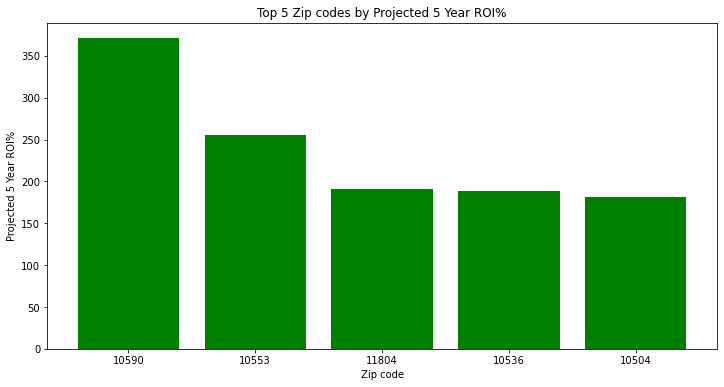

In [47]:
#Graphing the top 5 zip codes. "Zip code" column must be converted to string.
top_5_Zip_ROI = top_5_Zip_ROI.assign(Zipcode= (top_5_Zip_ROI['Zipcode'].apply(lambda x: str(x))))
fig, ax1 = plt.subplots(ncols=1, figsize=(12,6))
ax1.bar(
    x=top_5_Zip_ROI['Zipcode'],
    height=top_5_Zip_ROI['Projected 5 Year ROI%'], color='green'
)
ax1.set_title("Top 5 Zip codes by Projected 5 Year ROI%")

ax1.set_xlabel("Zip code")
ax1.set_ylabel("Projected 5 Year ROI%");

Now, I want to examine each zip code individually so I need a function that will predict future values and graph them along with the test and train data. The new wrinkle here is the addition of the baseline model which consists of shifting the data 1 year into the future.

In [48]:
def model_comparison(Suburban_zip):
    # Moving the data 12 months into the future
    baseline_burbs = Suburban_zip.shift(12)
    #80/20 split for each zipcode
    train, test = model_selection.train_test_split(Suburban_zip, train_size=.8)

    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                         max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                         stepwise=True, suppress_warnings=True, D=5, max_D=5,
                         error_action='ignore')
  
    #Creating the predictions. The test data comprises 53 months but I need to add a further 60 to get to 5 years.
    #conf_int returns confidence level at 95% level
    preds, conf_int = model.predict(n_periods=test.shape[0]+60, return_conf_int=True)
    

    
    print("Test RMSE for baseline: %.3f" % np.sqrt(mean_squared_error(Suburban_zip[12:], baseline_burbs[12:])))
    print("Test RMSE for model: %.3f" % np.sqrt(mean_squared_error(test, preds[:53])))
    ROI_percent=((preds[112]-test[52])/(test[52])*100)
    print(("Predicted ROI_percent: %.3f"%  ROI_percent))
    ROI_percent_real=((test[52]-train[211])/(train[211])*100)
    print(("Testing period ROI_percent: %.3f"%  ROI_percent_real))

    #Graphing, 'dates' is used as the x values while the train, test, and prediction values are the y values.
    plt.figure(figsize=(12,6))
    plt.plot(dates[:265],baseline_burbs)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Baseline'], loc='upper left') 
    plt.title(f'{Suburban_zip.name}  Baseline Prices')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(dates[:212], train)
    plt.plot(dates[212:265], test)
    plt.plot(dates[212:], preds, color='green')
    plt.fill_between(dates[212:], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{Suburban_zip.name} Prices and Next 5 year projections ')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(dates[:265], Suburban_zip)
    #plt.plot(dates[212:265], test)
    plt.plot(dates[:265],baseline_burbs)
    plt.plot(dates[212:], preds)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Actual Sales Data', 'Baseline', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{Suburban_zip.name} Prices and Next 5 year projections with Baseline')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    
    plt.show()
    
    
 
    
    
    
    


No.1, at 371.187%, is 10590. This zipcode is in Westchester County and includes parts of South Salem, NY and Lewisboro, NY.

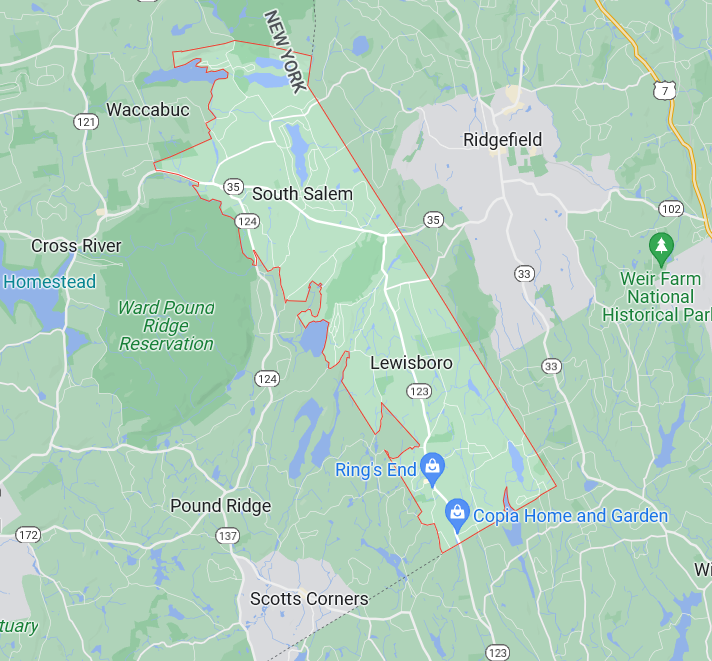

Test RMSE for baseline: 56830.818
Test RMSE for model: 497165.197
Predicted ROI_percent: 371.188
Testing period ROI_percent: 5.631


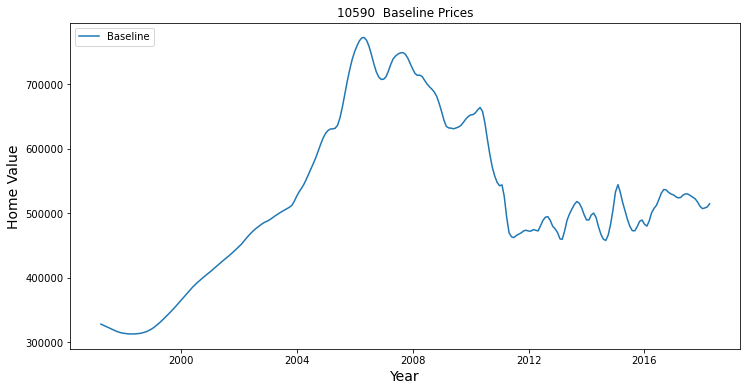

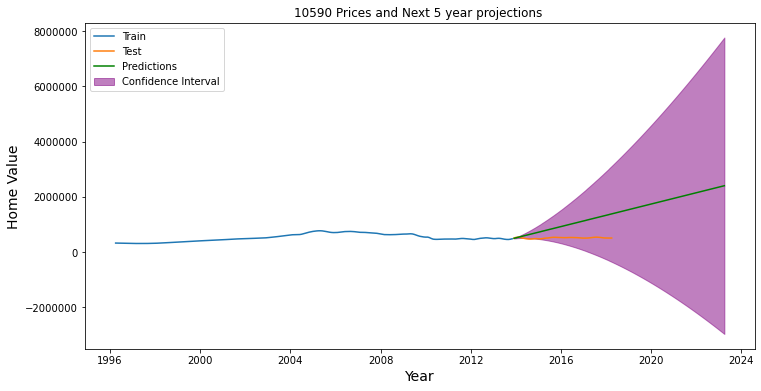

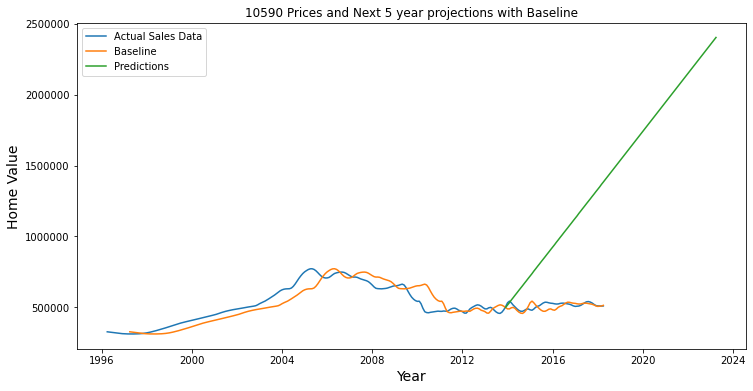

In [49]:
model_comparison(Suburbs[10590])

No. 2, at 255.495%, is 10553. This zipcode is in Westchester County and includes much of easter Mount Vernon, NY.

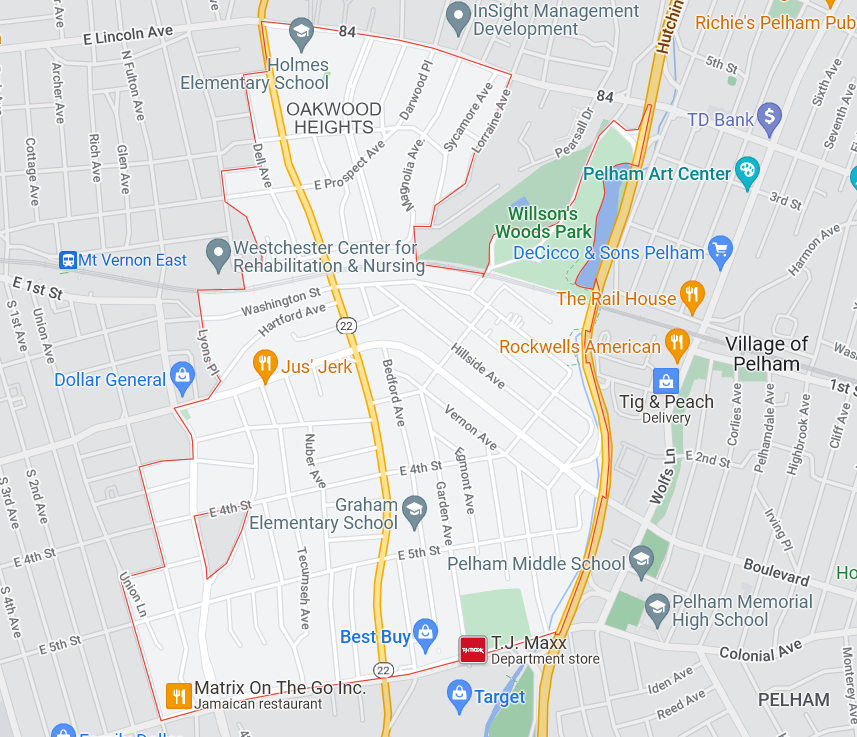

Test RMSE for baseline: 36555.793
Test RMSE for model: 186502.012
Predicted ROI_percent: 255.495
Testing period ROI_percent: 36.836


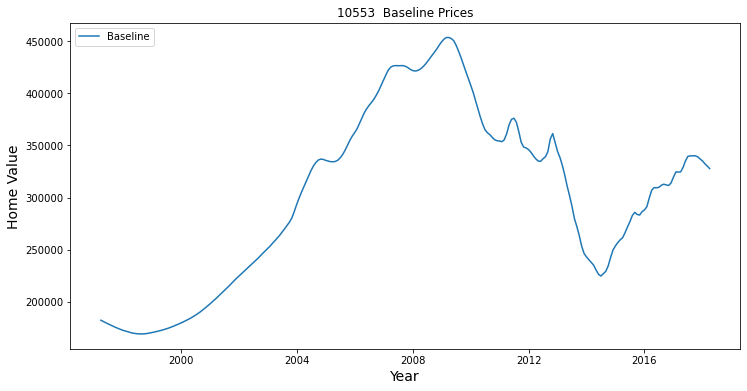

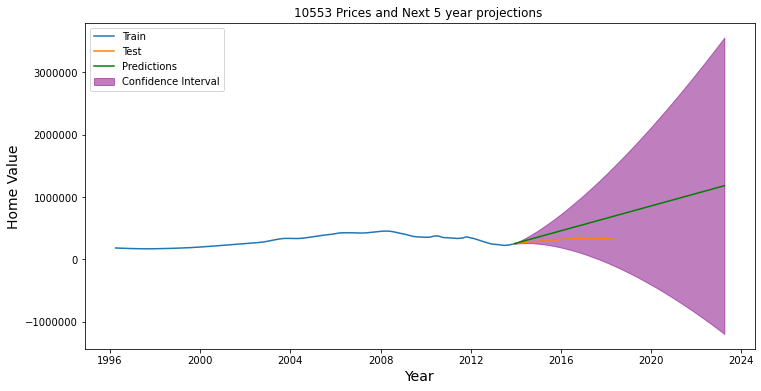

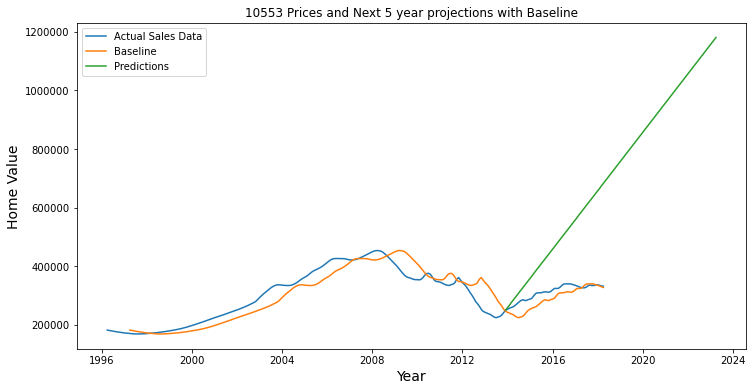

In [50]:
model_comparison(Suburbs[10553])

No. 3, at 190.459% is 11804. This zipcode is in Nassau County and contains Old Bethpage, NY and parts of Bethpage, NY.

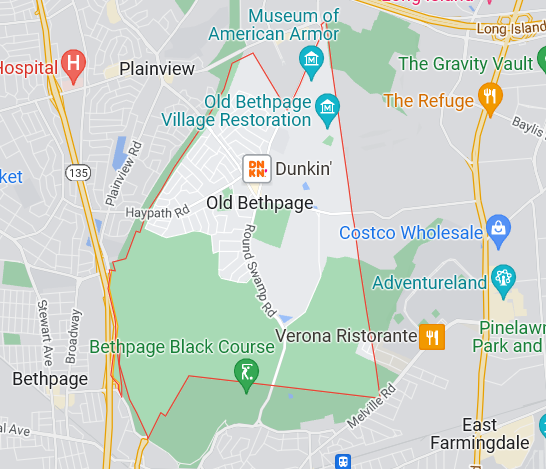

Test RMSE for baseline: 36671.901
Test RMSE for model: 278445.064
Predicted ROI_percent: 190.459
Testing period ROI_percent: 26.025


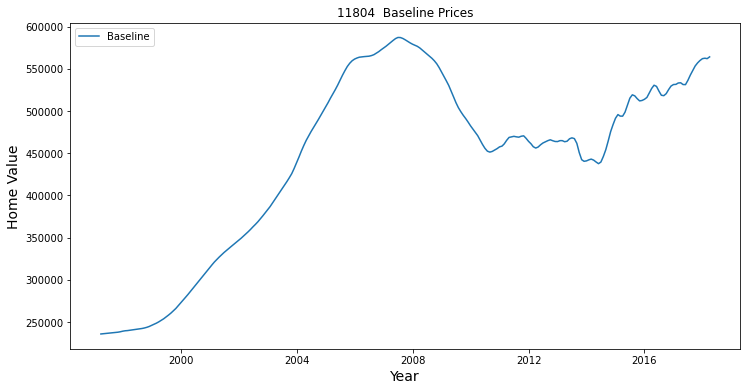

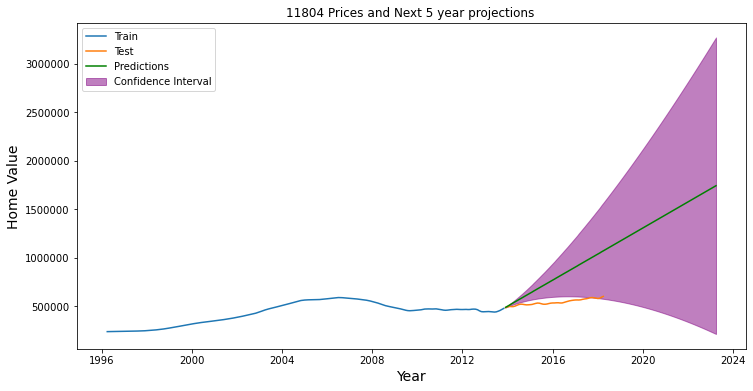

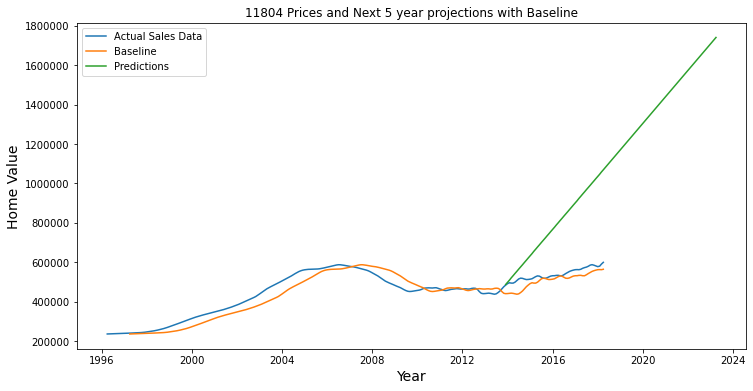

In [51]:
model_comparison(Suburbs[11804])

No. 4, at 204.643%,  is 188.629. This zipcode is in Westchester County and includes parts of Katonah, NY, Goldens Bridge, NY, and Whitehall Corners, NY.

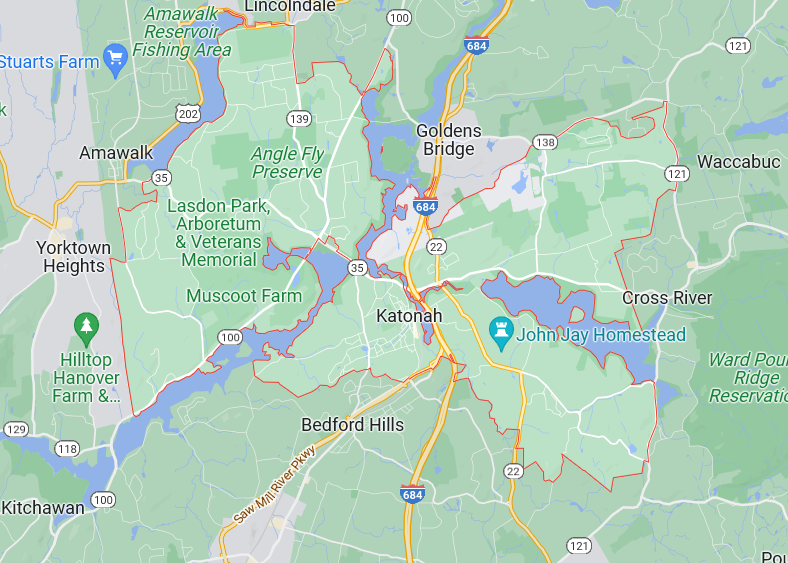

Test RMSE for baseline: 50051.282
Test RMSE for model: 336974.519
Predicted ROI_percent: 188.629
Testing period ROI_percent: 5.548


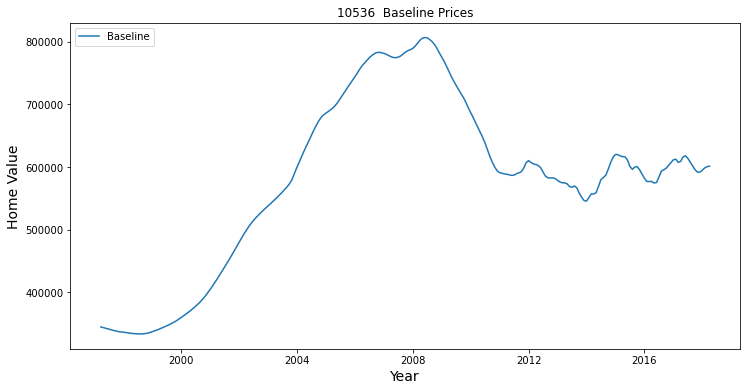

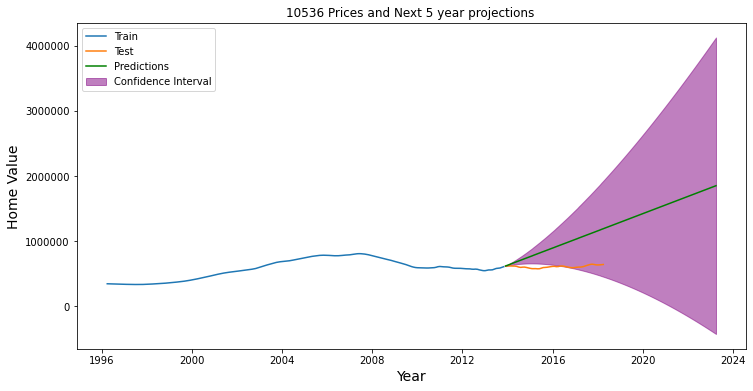

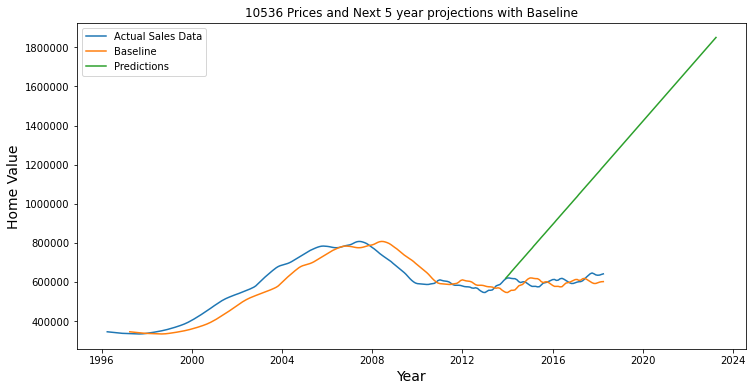

In [52]:
model_comparison(Suburbs[10536])




No. 5, at 180.919%, is 10504. This zipcode is in Nassau County and contains parts of Armonk, NY, Chappaqua, NY, and Valhalla, NY.

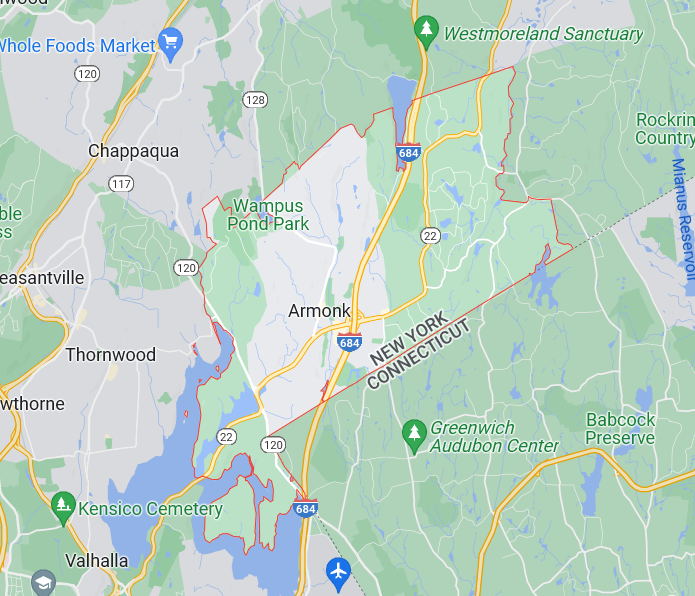

Test RMSE for baseline: 93168.259
Test RMSE for model: 492617.709
Predicted ROI_percent: 180.919
Testing period ROI_percent: -0.430


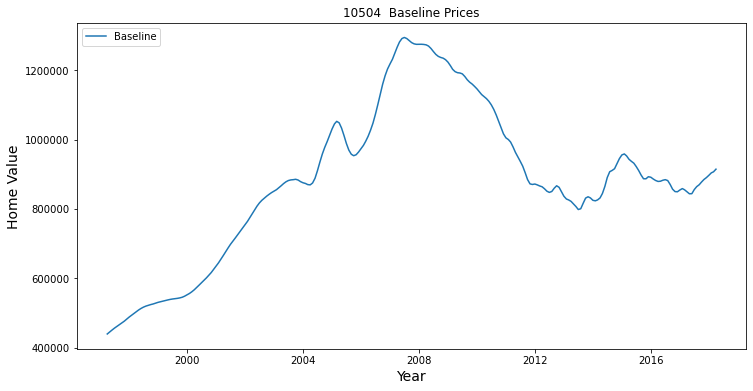

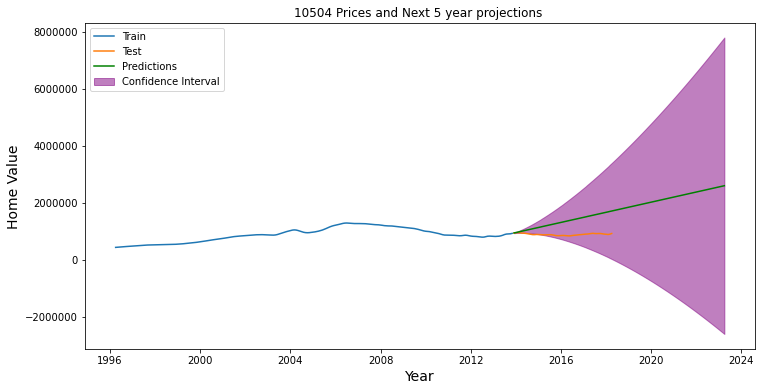

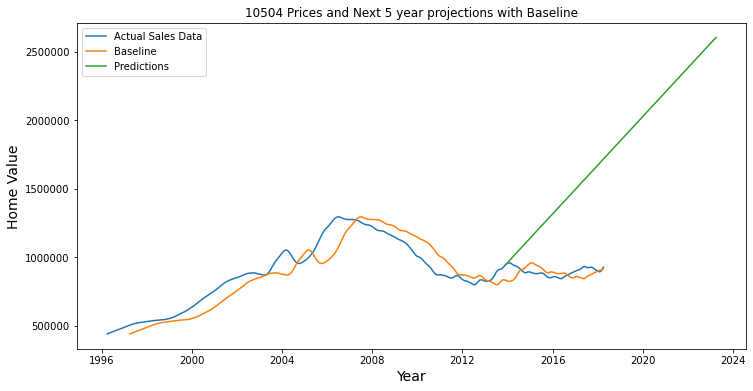

In [53]:
model_comparison(Suburbs[10504])

# CONCLUSION

According to the model, **the top 5 zip codes with the highest ROI% from May 2018 to March 2023 were 10590, 10553, 11804,  10536, and 10504**. For each zip code, the predicted value far outstripped both the actual value and the baseline value for the time period. The confidence intervals for each zip code prediction is also very large. In 4 of the zip codes, the confidence intervals veer into negative $ amounts. Overall, the wide discrepancy in the actual ROI and the predicted ROI  and the wide confidence intervals may raise doubts about the efficacy of the model and its predictions. 

However, there may be meaningful reasons for the difference in predicted and actual ROI and the wide confidence intervals. 
The wide confidence intervals are a product of either a small sample or a large degree of variation in the data. I cannot say whether the sample was big enough but the graphs of the prices suggest that the data has a high degree of variation. For each zip code in the dataset, there is a fall around the time of the Great Financial Crisis or GFC(circa 2008). The values start to rise again in 2011 and either stabilize or continue to increase. However, the larger trend, from 1996 to 2018, is a significant increase for most of the zip codes. To speculate a bit, the discrepancy evidenced in zip code value in the predicted data and the baseline and original data for the top 5 predicted values may simply be the model anticipating the prices to move at a similar rate to the rate that they were moving before the Great Financial Crisis or to a similar place to where they would have moved if there had been no GFC. If one were to draw a line from the pre-GFC peak to March 2023 for each of the top 5 predicted ROI zip codes then that line would approach the predicted value for March 2023.

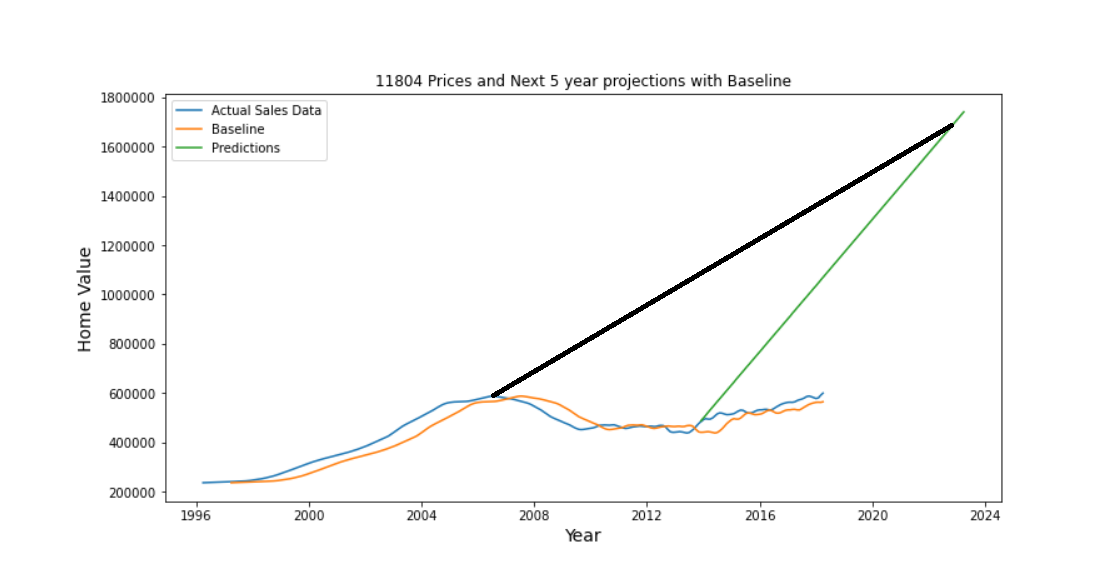

# NEXT STEPS
- An updated dataset that extends to 2022 would obviously be useful and would possibly generate more accurate predictions. It would also be interesting to see how a model would account for the COVID pandemic. The top 5 zipcodes would be especially interesting to look at since all of these zip codes except 10553 (which is solidly middle income) are wealthy suburbs with famously good schools where the average lot size is large and are full of residents who don't necessarily need to go into an office to work.
- More data on Fairfield County, CT would also be very useful to investors and to the model. Unfortunately, the Zillow dataset omitted many zip codes in Fairfield County, CT(parts of which are only a 40 minute train ride to Midtown, Manhattan and contain some of the wealthiest areas in the country) and also omitted data many zipcodes in the city itself. 
- Lastly, another ML model may yield more fruitful results. An XGBoost Regressor or a neural network model may yield better and more meaningful results.